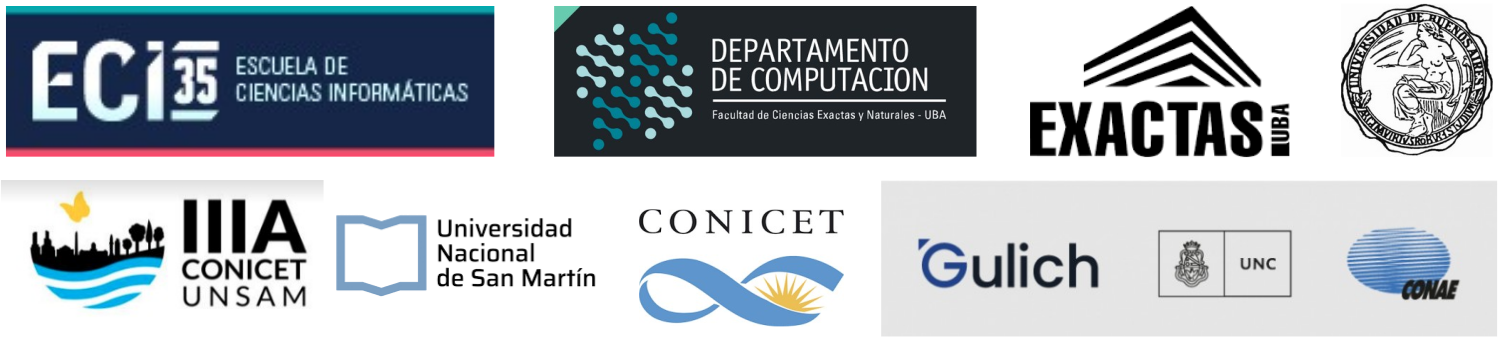
# Escuela de Ciencias Informáticas - 2022 - DC - FCEN - UBA
## Curso: Procesamiento de Imágenes Satelitales.  Docente: Rafael Grimson


---
#  Notebook 7: Imágenes Sentinel 2
---
Lo que veremos en esta notebook:

- [x] Imágenes Sentinel-2. Cartacterísticas.
- [x] Lectura por bandas. 
- [x] Minimum bounding box. Lecturas de recortes.
- [x] Lectura directa desde archivos comprimidos. 
---

### Objetivos de la notebook:

- En esta notebook esperamos que aprendas a leer recortes espaciales y espectrales de imágenes Sentinel-2 sin necesidad de descomprimirlas.

### Datos con los que trabajaremos en esta Notebook:

- Dos Sentinel-2 del dique Roggero en **data/raw_data/**:
    - **L1C_T21HUB_A017181_20181006T135109.zip**
    - **L1C_T21HUB_A023044_20191120T135113.zip**
- El archivo vectorial encuadrando la zona del Dique Roggero:
    - **data/raw_data/vector/zona_dique.geojson**

## 1. La misión Sentinel-2. 


### Bandas, resoluciones, frecuencia. Datos libres.
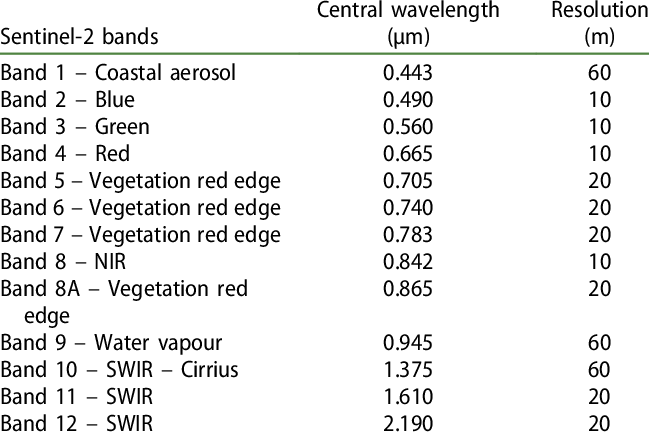

[Varias combinaciones de bandas para visualizacions diversas](https://gisgeography.com/sentinel-2-bands-combinations/)

## 2. T21HUB y Zona del Dique Roggero. 
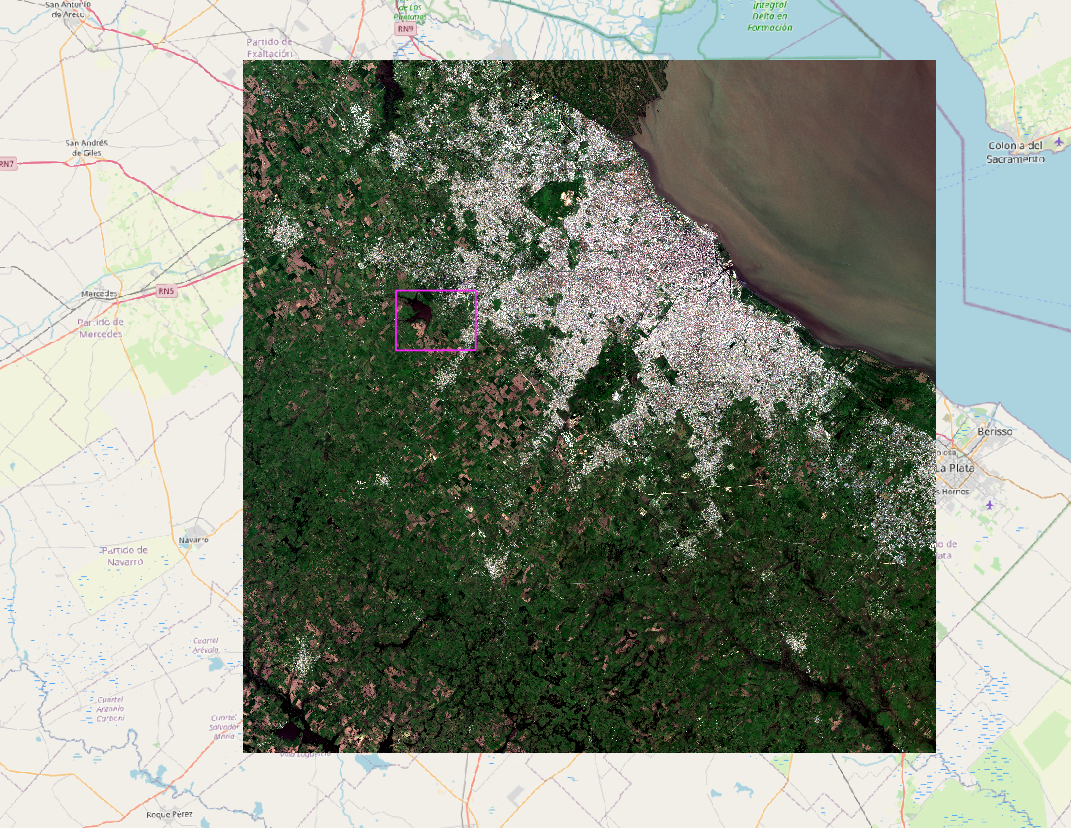

## 3. Lectura y escritura de recortes de Sentinel-2.

- La idea del mbb
- Lectura de (recorte o no) de bandas selccionadas
- Lectura directa del .zip


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import rasterio
from rasterio.plot import show
from rasterio.mask import mask
from shapely.geometry import shape

import geopandas as gpd

from funciones import *

Compute Minimum Bounding Box 

In [2]:
def compute_mbb(fn):
    """dado archivo vectorial (shp, geojson, etc) 
    calcula el mínimo rectángulo que contenga 
    su primer objeto"""

    gdf = gpd.read_file(fn)
    first_geom = gdf.iloc[0]['geometry'] #miro solo la primer geometría del archivo
    return first_geom.envelope


In [3]:
def compute_mbb(fn, snap_to_grid = True, grid_step = 10):
    """dado archivo vectorial (shp, geojson, etc) 
    calcula el mínimo rectángulo que contenga 
    su primer objeto, usando vértices 
    en una grilla de paso dado."""

    gdf = gpd.read_file(fn)
    first_geom = gdf.iloc[0]['geometry'] #miro solo la primer geometría del archivo

    mX, mY, MX, MY = first_geom.bounds
    if snap_to_grid:
        mX = grid_step*(np.floor(mX/grid_step))
        MX = grid_step*(np.ceil(MX/grid_step))
        mY = grid_step*(np.floor(mY/grid_step))
        MY = grid_step*(np.ceil(MY/grid_step))

    mbb = shape({'type': 'Polygon',
          'coordinates': [((mX, MY),
                           (MX, MY),
                           (MX, mY),
                           (mX, mY),
                           (mX, MY))]})
    return mbb

In [4]:
path_shp = 'data/raw_data/vector/'
mbb_dique = compute_mbb(path_shp+'zona_dique.geojson', grid_step = 100)

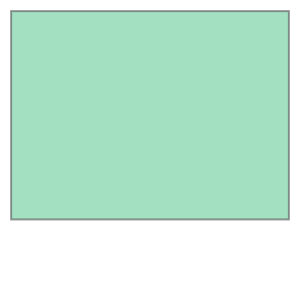

In [5]:
mbb_dique

## Vamos a usar diferente informacion y a tratar de guardarla ordenada

Vamos a empezar leyendo recortes (con mbb) de las bandas de 10m de resolución de una imagen Sentinel-2. Descomprimí el archio **L1C_T21HUB_A017181_20181006T135109.zip** en su misma carpeta.

Los pasos intermedios del procesamiento los vamos a guardar en un directorio _data/proc/_ y los de salida en _data/out/_

In [18]:
#original# path_in_img1 = 'data/raw_data/L1C_T21HUB_A017181_20181006T135109/S2A_MSIL1C_20181006T135111_N0206_R024_T21HUB_20181006T155043.SAFE/GRANULE/L1C_T21HUB_A017181_20181006T135109/IMG_DATA/'
path_in_img1 = 'data/raw_data/S2A_MSIL1C_20181006T135111_N0206_R024_T21HUB_20181006T155043.SAFE/GRANULE/L1C_T21HUB_A017181_20181006T135109/IMG_DATA/'
path_proc = 'data/proc/'
path_out = 'data/out/'

In [19]:
fn = 'T21HUB_20181006T135111_B02.jp2'#original
with rasterio.open(path_in_img1 + fn) as src:
    banda, out_transform = mask(src, [mbb_dique], crop=True)
    crs = src.crs
B_blue = np.true_divide(banda[0], 10000, dtype=np.float32)

In [20]:
fn = 'T21HUB_20181006T135111_B03.jp2'
with rasterio.open(path_in_img1 + fn) as src:
     banda, out_transform = mask(src, [mbb_dique], crop=True)
B_green = np.true_divide(banda[0], 10000, dtype=np.float32)# 10000 lo dice la escala de sentinel

fn = 'T21HUB_20181006T135111_B04.jp2'
with rasterio.open(path_in_img1 + fn) as src:
     banda, out_transform = mask(src, [mbb_dique], crop=True)
B_red = np.true_divide(banda[0], 10000, dtype=np.float32)

fn = 'T21HUB_20181006T135111_B08.jp2'
with rasterio.open(path_in_img1 + fn) as src:
     banda, out_transform = mask(src, [mbb_dique], crop=True)
B_nir = np.true_divide(banda[0], 10000, dtype=np.float32)

In [21]:
#computo de NDVI
B_ndvi = (B_nir- B_red)/(B_nir + B_red)

In [22]:
bandnames_B_G_R_NIR_NDVI =['Blue','Green','Red','NIR','NDVI']
guardar_GTiff(path_out + 'Dique_B_G_R_NIR_NDVI.tif',crs,out_transform,np.stack([B_blue,B_green,B_red,B_nir,B_ndvi]),bandnames=bandnames_B_G_R_NIR_NDVI)

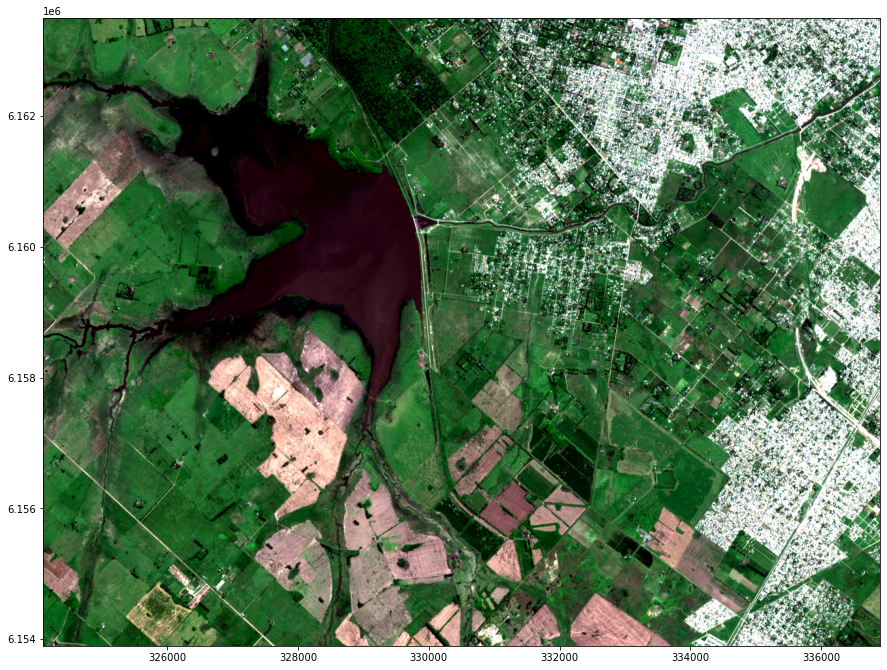

In [23]:
plt.figure(figsize=(15,15))
show(nequalize(np.stack([B_red,B_green,B_blue])),transform=out_transform)
plt.show()

In [24]:
#%%
def extract_10m_bands_Sentinel2(img_data_dir, mbb=None, compute_ndvi = True, verbose = True):
    """dado un directorio con las bandas de una Sentinel 2
    extrae las 4 bandas de 10m de resolucion (2, 3, 4 y 8) y computa el NDVI.
    Si se le pasa un polígono mbb en formato GJSON lo usa para recortar 
    la imagen, sino extrae la imagen completa.
    
    Devuelve la matriz con los datos extraídos, el crs y 
    la geotransformacion correspodientes"""
    
    ls = os.listdir(img_data_dir)
    band_names = ['B02.','B03.', 'B04.', 'B08.'] 
    bands = []
    for b in band_names:
        try:
            fn = [fn for fn in ls if b in fn][0]
        except:
            print(f"Banda {b} no encontrada en {img_data_dir}.")
        if verbose: print(f"Leyendo {fn}.")
        
        fn = os.path.join(img_data_dir,fn)
        with rasterio.open(fn) as src:
            crs=src.crs #recuerdo el sistema de referencia para poder grabar
            if mbb: #si hay mbb hago un clip
                array, out_transform = mask(src, [mbb], crop=True)
            else: #si no, uso la imagen entera
                array = src.read()
                out_transform = src.transform
        bands.append(np.true_divide(array[0], 10000, dtype=np.float32))
    if compute_ndvi:
        if verbose: print(f"Computando NDVI.")
        bands.append((bands[3]-bands[2])/(bands[3]+bands[2]))
    return np.stack(bands), crs, out_transform
    


In [25]:
S2_dique_20181006, crs, gt = extract_10m_bands_Sentinel2(path_in_img1, mbb=mbb_dique)

Leyendo T21HUB_20181006T135111_B02.jp2.
Leyendo T21HUB_20181006T135111_B03.jp2.
Leyendo T21HUB_20181006T135111_B04.jp2.
Leyendo T21HUB_20181006T135111_B08.jp2.
Computando NDVI.


In [26]:
S2_dique_20181006.shape

(5, 960, 1280)

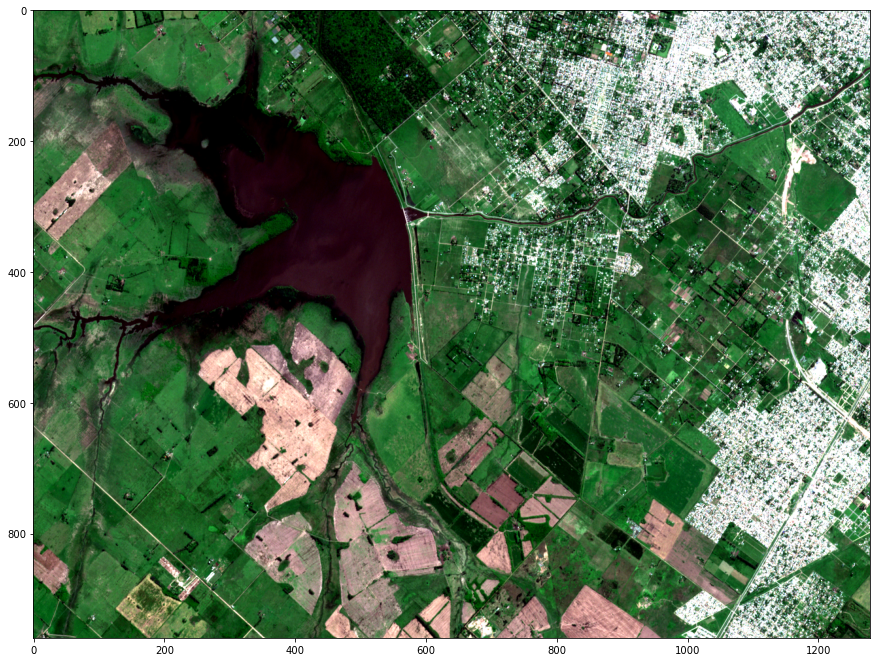

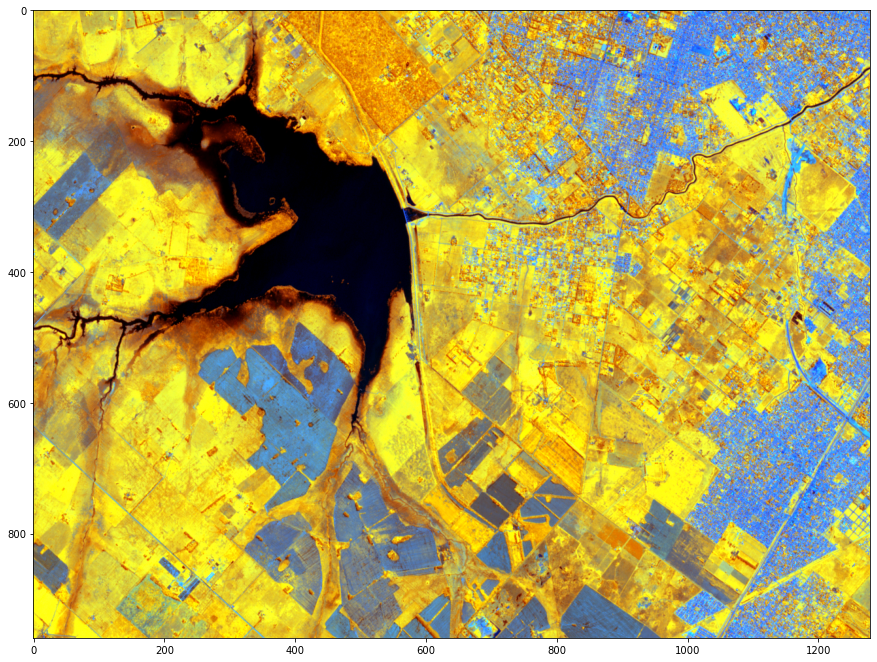

In [27]:
plt.figure(figsize=(15,15))
show(nequalize(S2_dique_20181006[[2,1,0]]))
plt.show()

plt.figure(figsize=(15,15))
show(nequalize(S2_dique_20181006[[4,3,0]]))
plt.show()


O directamente del archivo ZIP

In [28]:
from zipfile import ZipFile
import re
import os

# Procesar Sentinel2
def extract_10m_bands_Sentinel2_ZIP(zipfilename, mbb=None, compute_ndvi = True, verbose = True):
    """dado un zip de una Sentinel 2
    extrae las 4 bandas de 10m de resolucion (2, 3, 4 y 8) y computa el NDVI.
    Si se le pasa un polígono mbb en formato GJSON lo usa para recortar 
    la imagen, sino extrae la imagen completa.
    
    Devuelve la matriz con los datos extraídos, el crs y 
    la geotransformacion correspodientes"""
    
    ## vsizip bugfix
    os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'

    ## look for 10m resolution bands: 02, 03, 04 and 08
    tileREXP = re.compile(r'.*_B(02|03|04|08).jp2$')
    if verbose: print(f'Leyendo ZIP {zipfilename}')

    bands = []
    with ZipFile(zipfilename,'r') as zfile:
        bandfns = [x for x in zfile.namelist() if re.match(tileREXP,x)]
        bandfns.sort()
        for bandfn in bandfns:
            fn = f'/vsizip/{zipfilename}/{bandfn}'
            if verbose: print(f'Leyendo {os.path.basename(fn)}.')
            with rasterio.open(fn) as src:
                crs=src.crs #recuerdo el sistema de referencia para poder grabar
                if mbb: #si hay mbb hago un clip
                    array, out_transform = mask(src, [mbb], crop=True)
                else: #si no, uso la imagen entera
                    array = src.read()
                    out_transform = src.transform
            bands.append(np.true_divide(array[0], 10000, dtype=np.float32))
    if compute_ndvi:
        if verbose: print(f'Computando NDVI.')
        bands.append((bands[3]-bands[2])/(bands[3]+bands[2]))
    return np.stack(bands), crs, out_transform


In [29]:
data_dir = 'data/raw_data/'
fn_zip='L1C_T21HUB_A017181_20181006T135109.zip'
S2_dique_20181006, crs, gt = extract_10m_bands_Sentinel2_ZIP(data_dir + fn_zip, mbb=mbb_dique)

Leyendo ZIP data/raw_data/L1C_T21HUB_A017181_20181006T135109.zip
Leyendo T21HUB_20181006T135111_B02.jp2.
Leyendo T21HUB_20181006T135111_B03.jp2.
Leyendo T21HUB_20181006T135111_B04.jp2.
Leyendo T21HUB_20181006T135111_B08.jp2.
Computando NDVI.


In [30]:
guardar_GTiff(path_proc + 'S2_dique_20181006.tif',crs,gt,S2_dique_20181006,bandnames=bandnames_B_G_R_NIR_NDVI)

### Ejercicio 7.1 
    1. Leer la otra imagen Sentinel-2 del mismo directorio (la de fecha 2019-11-20) y guardar el mismo recorte `mbb_dique`. Mirar ambas imágenes en QGIS.